In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
cars = pd.read_csv('datasets/car.data', header=None)
cars.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [3]:
columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'label']
cars.columns = columns
cars.head()

,buying,maint,doors,persons,lug_boot,safety,label
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
cars.describe()

,buying,maint,doors,persons,lug_boot,safety,label
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


In [5]:
cars['label'].value_counts()

label
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64

In [6]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   label     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [7]:
for column in cars.columns:
    cars[column] = cars[column].astype('category')
cars.dtypes

buying      category
maint       category
doors       category
persons     category
lug_boot    category
safety      category
label       category
dtype: object

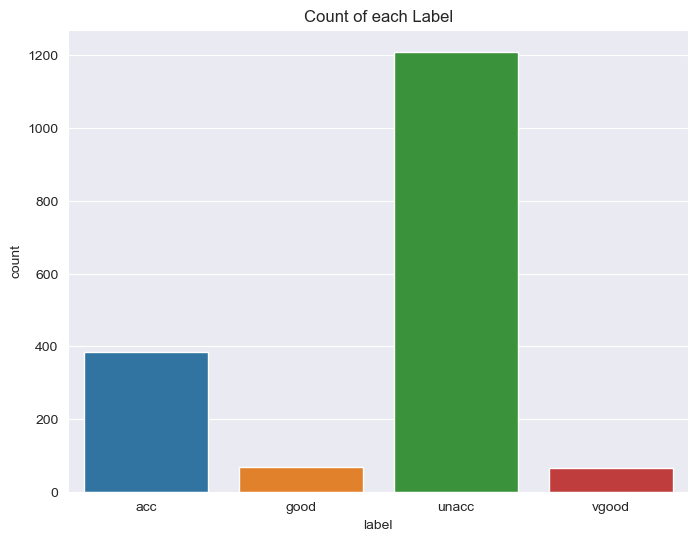

In [8]:
plt.figure(figsize=(8, 6))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of each Label')

sns.countplot(x='label', data=cars)
plt.show()

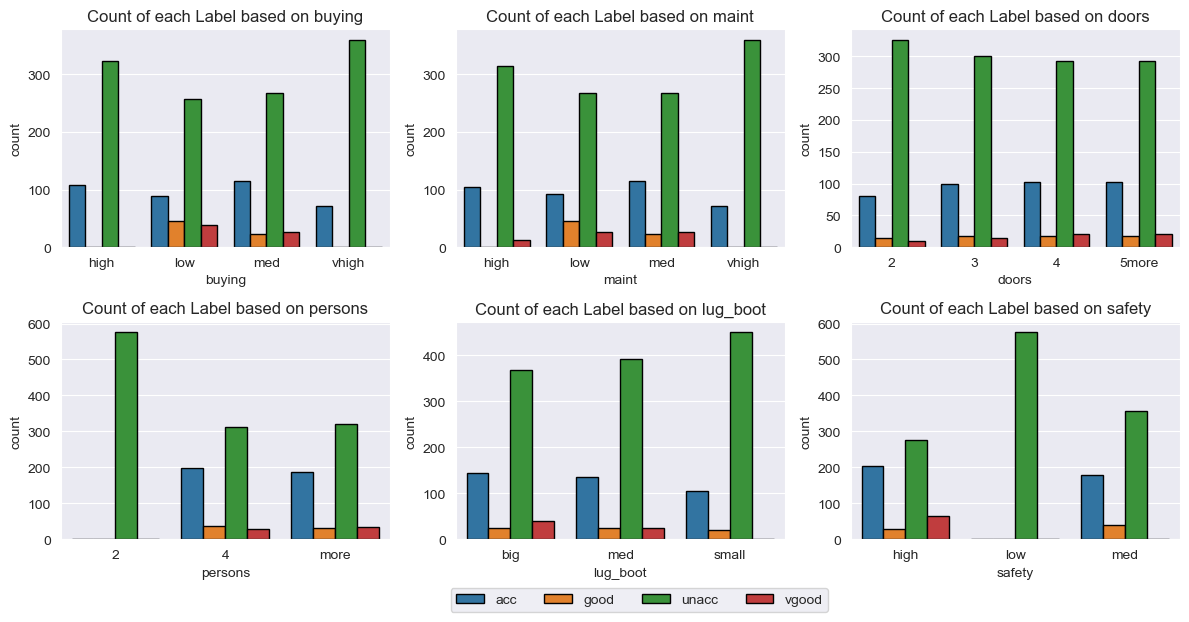

In [9]:
features = np.array(cars.columns[:-1])

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.ravel()

for i in range(len(features)):
    sns.countplot(x=features[i], hue='label', data=cars, ax=axes[i], edgecolor='black')
    axes[i].set_title('Count of each Label based on {}'.format(features[i]))
    axes[i].legend([], [], frameon=False)

plt.tight_layout()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='right', ncol=4, bbox_to_anchor=(.7, -0.01))
plt.show()

In [10]:
train_data, test_data = train_test_split(cars, test_size=0.3, random_state=42)

In [11]:
class NaiveBayes:
    def train(self, train_data, label_column):
        self.model = {}
        self.label_column = label_column
        features = train_data.drop(label_column, axis=1)
        self.feature_columns = features.columns

        # Calculate the labels probability
        for label in train_data[label_column].unique():
            label_count = train_data[train_data[label_column] == label][label_column].count()
            self.model[label] = label_count / train_data.shape[0]

        # Calculate the features probability
        for column in self.feature_columns:
            feature_crosstab = pd.crosstab(train_data[column], train_data[label_column], margins=True).unstack().reorder_levels((column, label_column))
            feature_categories = train_data[column].unique()
            column_bayes = {}
            for category in feature_categories:
                category_bayes = {}
                for label in train_data[label_column]:
                    bayes = feature_crosstab.loc[category, label] / feature_crosstab.loc['All', label]
                    category_bayes[label] = bayes
                column_bayes[category] = category_bayes
            self.model[column] = column_bayes

        

In [12]:
model = NaiveBayes()
model.train(train_data, 'label')

In [13]:
model.model

{'vgood': 0.03391232423490488,
 'unacc': 0.7047146401985112,
 'acc': 0.22001654259718775,
 'good': 0.0413564929693962,
 'buying': {'med': {'vgood': 0.4146341463414634,
   'unacc': 0.2300469483568075,
   'acc': 0.2894736842105263,
   'good': 0.36},
  'high': {'vgood': 0.0,
   'unacc': 0.2605633802816901,
   'acc': 0.2894736842105263,
   'good': 0.0},
  'low': {'vgood': 0.5853658536585366,
   'unacc': 0.21009389671361503,
   'acc': 0.23308270676691728,
   'good': 0.64},
  'vhigh': {'vgood': 0.0,
   'unacc': 0.2992957746478873,
   'acc': 0.18796992481203006,
   'good': 0.0}},
 'maint': {'med': {'vgood': 0.3170731707317073,
   'unacc': 0.22769953051643194,
   'acc': 0.31954887218045114,
   'good': 0.3},
  'high': {'vgood': 0.24390243902439024,
   'unacc': 0.26291079812206575,
   'acc': 0.2631578947368421,
   'good': 0.0},
  'vhigh': {'vgood': 0.0,
   'unacc': 0.2992957746478873,
   'acc': 0.18045112781954886,
   'good': 0.0},
  'low': {'vgood': 0.43902439024390244,
   'unacc': 0.2100938967